### Experimenting with RandomForestRegressor Using a Combination of Categorical & Numerical Variables, Target is Price

In [1]:
# Import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Import cleaned dataset
cleaned_airbnb_df = pd.read_csv("Resources/cleaned_airbnb_dataset4.csv", index_col=0)
cleaned_airbnb_df

,host_id,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,...,latitude,longitude,reviews,review_scores_rating,price,cleaning_fee,total,Median,Mean,Pop
room_id,,,,,,,,,,,,,,,,,,,,,
958,1169,t,Apartment,Entire home/apt,Western Addition,94117,3,1.0,1.0,1,...,37.76931,-122.43386,217,97.0,170.0,100.0,270.0,84802.0,112291.0,39169.0
3850,4921,t,House,Private room,Inner Sunset,94131,2,1.0,1.0,1,...,37.75402,-122.45805,160,94.0,99.0,10.0,109.0,97834.0,126303.0,26881.0
5858,8904,f,Apartment,Entire home/apt,Bernal Heights,94110,5,2.0,1.0,30,...,37.74511,-122.42102,111,98.0,235.0,100.0,335.0,75106.0,98470.0,69333.0
7918,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.0,4.0,32,...,37.76669,-122.45250,18,86.0,65.0,50.0,115.0,84802.0,112291.0,39169.0
8142,21994,t,Apartment,Private room,Haight Ashbury,94117,2,1.0,4.0,32,...,37.76487,-122.45183,8,93.0,65.0,50.0,115.0,84802.0,112291.0,39169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39337552,4996407,f,Guest suite,Entire home/apt,Haight Ashbury,94117,4,1.0,1.0,2,...,37.77183,-122.43730,0,0.0,113.0,75.0,188.0,84802.0,112291.0,39169.0
39342094,4332552,f,House,Private room,Bernal Heights,94110,5,3.0,2.0,30,...,37.74010,-122.41196,0,0.0,699.0,150.0,849.0,75106.0,98470.0,69333.0
39343373,245447609,f,Condominium,Entire home/apt,Downtown/Civic Center,94102,4,1.0,1.0,1,...,37.77799,-122.42159,0,0.0,200.0,0.0,200.0,29613.0,44237.0,31176.0


In [3]:
# Look at property_type value counts for binning
property_type_counts = cleaned_airbnb_df.property_type.value_counts()
property_type_counts

Apartment             3049
House                 2267
Condominium            853
Guest suite            573
Boutique hotel         267
Hotel                  152
Townhouse              139
Serviced apartment     120
Hostel                  92
Loft                    86
Bed and breakfast       42
Aparthotel              41
Guesthouse              41
Other                   24
Bungalow                17
Resort                  14
Cottage                 12
Villa                   10
Castle                   4
Tiny house               3
Cabin                    3
Earth house              2
Dome house               1
Camper/RV                1
Hut                      1
In-law                   1
Name: property_type, dtype: int64

In [4]:
# Determine which values to replace if property_type counts are less than 80
replace_property_type = list(property_type_counts[property_type_counts < 80].index)

# Replace in dataframe
for prop in replace_property_type:
    cleaned_airbnb_df.property_type = cleaned_airbnb_df.property_type.replace(prop,"Other")
    
# Check to make sure binning was successful
cleaned_airbnb_df.property_type.value_counts()

Apartment             3049
House                 2267
Condominium            853
Guest suite            573
Boutique hotel         267
Other                  217
Hotel                  152
Townhouse              139
Serviced apartment     120
Hostel                  92
Loft                    86
Name: property_type, dtype: int64

In [5]:
# Look at neighborhood value counts for binning 
neighborhood_counts = cleaned_airbnb_df.neighborhood.value_counts()
neighborhood_counts

Mission                  744
Downtown/Civic Center    660
South of Market          627
Western Addition         595
Castro/Upper Market      424
Haight Ashbury           389
Bernal Heights           387
Noe Valley               331
Outer Sunset             295
Nob Hill                 286
Potrero Hill             231
Inner Richmond           210
Bayview                  202
Marina                   197
Outer Richmond           182
Excelsior                179
Outer Mission            174
Inner Sunset             171
North Beach              171
Financial District       170
Russian Hill             166
Pacific Heights          151
West of Twin Peaks       136
Parkside                 130
Ocean View               120
Chinatown                112
Visitacion Valley         79
Twin Peaks                67
Glen Park                 65
Lakeshore                 61
Crocker Amazon            39
Seacliff                  22
Presidio Heights          19
Diamond Heights           17
Golden Gate Pa

In [6]:
# Determine which values to replace if neighborhood counts are less than 100
replace_neighborhood = list(neighborhood_counts[neighborhood_counts < 100].index)

# Replace in dataframe
for hood in replace_neighborhood:
    cleaned_airbnb_df.neighborhood = cleaned_airbnb_df.neighborhood.replace(hood,"Other")
    
# Check to make sure binning was successful
cleaned_airbnb_df.neighborhood.value_counts()

Mission                  744
Downtown/Civic Center    660
South of Market          627
Western Addition         595
Castro/Upper Market      424
Haight Ashbury           389
Bernal Heights           387
Other                    375
Noe Valley               331
Outer Sunset             295
Nob Hill                 286
Potrero Hill             231
Inner Richmond           210
Bayview                  202
Marina                   197
Outer Richmond           182
Excelsior                179
Outer Mission            174
Inner Sunset             171
North Beach              171
Financial District       170
Russian Hill             166
Pacific Heights          151
West of Twin Peaks       136
Parkside                 130
Ocean View               120
Chinatown                112
Name: neighborhood, dtype: int64

In [7]:
# Look at zipcode value counts for binning
zip_counts = cleaned_airbnb_df.zipcode.value_counts()
zip_counts

94110    978
94117    675
94114    638
94109    606
94103    491
94102    486
94112    403
94107    366
94122    353
94115    303
94131    280
94108    273
94133    250
94121    222
94123    221
94118    217
94116    198
94124    195
94134    151
94127    139
94105    137
94132     92
94158     77
94111     50
94104     11
94129      1
94113      1
94130      1
Name: zipcode, dtype: int64

In [8]:
# Determine which values to replace if zipcode counts are less than 100
replace_zipcode = list(zip_counts[zip_counts < 100].index)

# Replace in dataframe
for zcode in replace_zipcode:
    cleaned_airbnb_df.zipcode = cleaned_airbnb_df.zipcode.replace(zcode,"Other")
    
# Check to make sure binning was successful
cleaned_airbnb_df.zipcode.value_counts()

94110    978
94117    675
94114    638
94109    606
94103    491
94102    486
94112    403
94107    366
94122    353
94115    303
94131    280
94108    273
94133    250
Other    233
94121    222
94123    221
94118    217
94116    198
94124    195
94134    151
94127    139
94105    137
Name: zipcode, dtype: int64

In [9]:
# Define the categorical features set X, called categorical_df.
# copy cleaned_airbnb_df and save as categorical_df
categorical_df = cleaned_airbnb_df.copy()

# drop host_id, latitude, longitude (not needed), 
# drop numerical variables (accomodates, bedrooms, bathrooms, minimum_nights, maximumn_nights, reviews, review_scores_rating,
#  Median, Mean, Pop)
# drop cleaning_fee and total
categorical_df = categorical_df.drop(["host_id", "latitude", "longitude", "accommodates", "bedrooms", "bathrooms",
                                     "minimum_nights", "maximum_nights", "reviews", "review_scores_rating", "Median",
                                     "Mean", "Pop", "cleaning_fee", "total"], axis=1)

categorical_df

,host_is_superhost,property_type,room_type,neighborhood,zipcode,price
room_id,,,,,,
958,t,Apartment,Entire home/apt,Western Addition,94117,170.0
3850,t,House,Private room,Inner Sunset,94131,99.0
5858,f,Apartment,Entire home/apt,Bernal Heights,94110,235.0
7918,t,Apartment,Private room,Haight Ashbury,94117,65.0
8142,t,Apartment,Private room,Haight Ashbury,94117,65.0
...,...,...,...,...,...,...
39337552,f,Guest suite,Entire home/apt,Haight Ashbury,94117,113.0
39342094,f,House,Private room,Bernal Heights,94110,699.0
39343373,f,Condominium,Entire home/apt,Downtown/Civic Center,94102,200.0


In [10]:
# Define the numerical features set X, called numerical_df.
# copy cleaned_airbnb_df and save as categorical_df
numerical_df = cleaned_airbnb_df.copy()

# drop host_id, latitude, longitude, Mean, Pop (not needed), 
# drop categorical variables (host_is_superhost, propert_type, room_type, neighborhood, zipcode)
# drop cleaning_fee and total
numerical_df = numerical_df.drop(["host_id", "host_is_superhost", "property_type", "room_type", "neighborhood", "zipcode",
                                  "latitude", "longitude", "Mean", "Pop", "cleaning_fee", "total"], axis=1)

numerical_df

,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,reviews,review_scores_rating,price,Median
room_id,,,,,,,,,
958,3,1.0,1.0,1,30,217,97.0,170.0,84802.0
3850,2,1.0,1.0,1,5,160,94.0,99.0,97834.0
5858,5,2.0,1.0,30,60,111,98.0,235.0,75106.0
7918,2,1.0,4.0,32,60,18,86.0,65.0,84802.0
8142,2,1.0,4.0,32,90,8,93.0,65.0,84802.0
...,...,...,...,...,...,...,...,...,...
39337552,4,1.0,1.0,2,1125,0,0.0,113.0,84802.0
39342094,5,3.0,2.0,30,1125,0,0.0,699.0,75106.0
39343373,4,1.0,1.0,1,7,0,0.0,200.0,29613.0


In [11]:
# drop "price", this is the target
categorical_df = categorical_df.drop("price", axis=1)
categorical_df

,host_is_superhost,property_type,room_type,neighborhood,zipcode
room_id,,,,,
958,t,Apartment,Entire home/apt,Western Addition,94117
3850,t,House,Private room,Inner Sunset,94131
5858,f,Apartment,Entire home/apt,Bernal Heights,94110
7918,t,Apartment,Private room,Haight Ashbury,94117
8142,t,Apartment,Private room,Haight Ashbury,94117
...,...,...,...,...,...
39337552,f,Guest suite,Entire home/apt,Haight Ashbury,94117
39342094,f,House,Private room,Bernal Heights,94110
39343373,f,Condominium,Entire home/apt,Downtown/Civic Center,94102


In [12]:
# room_type only
categorical_room_type_df = categorical_df.drop(["host_is_superhost", "property_type", "neighborhood", "zipcode"], axis=1)
categorical_room_type_df

,room_type
room_id,
958,Entire home/apt
3850,Private room
5858,Entire home/apt
7918,Private room
8142,Private room
...,...
39337552,Entire home/apt
39342094,Private room
39343373,Entire home/apt


In [13]:
# Encode the categorical features
# Binary encoding using Pandas (multiple columns)
encoded_categorical_df = pd.get_dummies(categorical_df, columns=["host_is_superhost", "property_type", "room_type",
                                                                "neighborhood", "zipcode"])
encoded_categorical_df

,host_is_superhost_f,host_is_superhost_t,property_type_Apartment,property_type_Boutique hotel,property_type_Condominium,property_type_Guest suite,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,...,zipcode_94118,zipcode_94121,zipcode_94122,zipcode_94123,zipcode_94124,zipcode_94127,zipcode_94131,zipcode_94133,zipcode_94134,zipcode_Other
room_id,,,,,,,,,,,,,,,,,,,,,
958,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3850,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
5858,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7918,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8142,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39337552,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39342094,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
39343373,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Encode the categorical features - room_type only
# Binary encoding using Pandas (multiple columns)
encoded_categorical_room_type_df = pd.get_dummies(categorical_room_type_df, columns=["room_type"])
encoded_categorical_room_type_df

,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
room_id,,,,
958,1,0,0,0
3850,0,0,1,0
5858,1,0,0,0
7918,0,0,1,0
8142,0,0,1,0
...,...,...,...,...
39337552,1,0,0,0
39342094,0,0,1,0
39343373,1,0,0,0


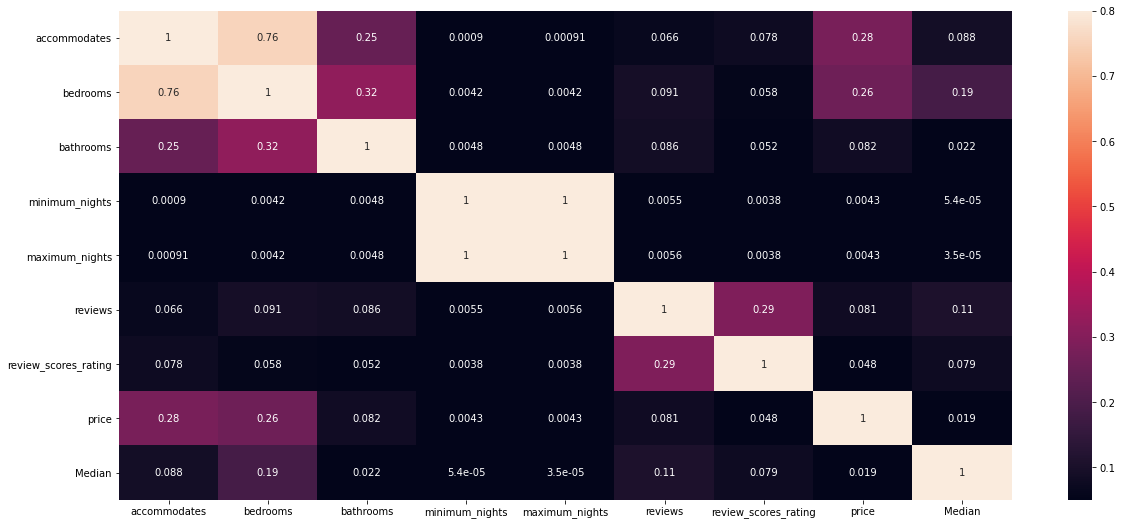

In [15]:
# heatmap
cmx = numerical_df.corr()
cmx = abs(cmx)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(cmx, vmax=0.8, vmin=0.05, annot=True)
plt.show()

In [16]:
# drop "price", this is the target
numerical_df = numerical_df.drop("price", axis=1)
numerical_df

,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,reviews,review_scores_rating,Median
room_id,,,,,,,,
958,3,1.0,1.0,1,30,217,97.0,84802.0
3850,2,1.0,1.0,1,5,160,94.0,97834.0
5858,5,2.0,1.0,30,60,111,98.0,75106.0
7918,2,1.0,4.0,32,60,18,86.0,84802.0
8142,2,1.0,4.0,32,90,8,93.0,84802.0
...,...,...,...,...,...,...,...,...
39337552,4,1.0,1.0,2,1125,0,0.0,84802.0
39342094,5,3.0,2.0,30,1125,0,0.0,75106.0
39343373,4,1.0,1.0,1,7,0,0.0,29613.0


In [17]:
numerical_df2 = numerical_df.drop("Median", axis=1)
numerical_df2

,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,reviews,review_scores_rating
room_id,,,,,,,
958,3,1.0,1.0,1,30,217,97.0
3850,2,1.0,1.0,1,5,160,94.0
5858,5,2.0,1.0,30,60,111,98.0
7918,2,1.0,4.0,32,60,18,86.0
8142,2,1.0,4.0,32,90,8,93.0
...,...,...,...,...,...,...,...
39337552,4,1.0,1.0,2,1125,0,0.0
39342094,5,3.0,2.0,30,1125,0,0.0
39343373,4,1.0,1.0,1,7,0,0.0


In [18]:
numerical_df3 = numerical_df2.drop("reviews", axis=1)
numerical_df3

,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,review_scores_rating
room_id,,,,,,
958,3,1.0,1.0,1,30,97.0
3850,2,1.0,1.0,1,5,94.0
5858,5,2.0,1.0,30,60,98.0
7918,2,1.0,4.0,32,60,86.0
8142,2,1.0,4.0,32,90,93.0
...,...,...,...,...,...,...
39337552,4,1.0,1.0,2,1125,0.0
39342094,5,3.0,2.0,30,1125,0.0
39343373,4,1.0,1.0,1,7,0.0


In [19]:
# create new dataframe with only accommodates, bedrooms, bathrooms and reviews
four_numerical_features_df = numerical_df.copy()
four_numerical_features_df = four_numerical_features_df.drop(["minimum_nights", "maximum_nights", 
                                                              "review_scores_rating", "Median"], axis=1)
four_numerical_features_df

,accommodates,bedrooms,bathrooms,reviews
room_id,,,,
958,3,1.0,1.0,217
3850,2,1.0,1.0,160
5858,5,2.0,1.0,111
7918,2,1.0,4.0,18
8142,2,1.0,4.0,8
...,...,...,...,...
39337552,4,1.0,1.0,0
39342094,5,3.0,2.0,0
39343373,4,1.0,1.0,0


In [20]:
# create new dataframe with only accommodates, bedrooms, minimum_nights, maximum_nights and reviews
five_numerical_features_df = numerical_df.copy()
five_numerical_features_df = five_numerical_features_df.drop(["bathrooms", "review_scores_rating", "Median"], axis=1)
five_numerical_features_df

,accommodates,bedrooms,minimum_nights,maximum_nights,reviews
room_id,,,,,
958,3,1.0,1,30,217
3850,2,1.0,1,5,160
5858,5,2.0,30,60,111
7918,2,1.0,32,60,18
8142,2,1.0,32,90,8
...,...,...,...,...,...
39337552,4,1.0,2,1125,0
39342094,5,3.0,30,1125,0
39343373,4,1.0,1,7,0


In [21]:
# create new dataframe with only accommodates and bedrooms 
two_numerical_features_df = numerical_df.copy()
two_numerical_features_df = two_numerical_features_df.drop(["bathrooms", "minimum_nights", "maximum_nights", "reviews",
                                                            "review_scores_rating", "Median"], axis=1)
two_numerical_features_df

,accommodates,bedrooms
room_id,,
958,3,1.0
3850,2,1.0
5858,5,2.0
7918,2,1.0
8142,2,1.0
...,...,...
39337552,4,1.0
39342094,5,3.0
39343373,4,1.0


In [22]:
# create new dataframe with accommodates, bedrooms, minimum_nights and review_scores_rating
four_other_numerical_features_df = numerical_df.copy()
four_other_numerical_features_df = four_other_numerical_features_df.drop(["bathrooms", "maximum_nights", "reviews", 
                                                                          "Median"], axis=1)

In [23]:
four_other_numerical_features_df

,accommodates,bedrooms,minimum_nights,review_scores_rating
room_id,,,,
958,3,1.0,1,97.0
3850,2,1.0,1,94.0
5858,5,2.0,30,98.0
7918,2,1.0,32,86.0
8142,2,1.0,32,93.0
...,...,...,...,...
39337552,4,1.0,2,0.0
39342094,5,3.0,30,0.0
39343373,4,1.0,1,0.0


In [24]:
# create new dataframe with room_type and accommodates, bedrooms, minimum_nights and review_scores_rating
room_four_other_features_df = pd.concat([encoded_categorical_room_type_df, four_other_numerical_features_df], axis=1)

room_four_other_features_df

,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,accommodates,bedrooms,minimum_nights,review_scores_rating
room_id,,,,,,,,
958,1,0,0,0,3,1.0,1,97.0
3850,0,0,1,0,2,1.0,1,94.0
5858,1,0,0,0,5,2.0,30,98.0
7918,0,0,1,0,2,1.0,32,86.0
8142,0,0,1,0,2,1.0,32,93.0
...,...,...,...,...,...,...,...,...
39337552,1,0,0,0,4,1.0,2,0.0
39342094,0,0,1,0,5,3.0,30,0.0
39343373,1,0,0,0,4,1.0,1,0.0


In [25]:
# create new dataframe with with all features
data_complete_df = pd.concat([encoded_categorical_df, numerical_df], axis=1)

data_complete_df

,host_is_superhost_f,host_is_superhost_t,property_type_Apartment,property_type_Boutique hotel,property_type_Condominium,property_type_Guest suite,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,...,zipcode_94134,zipcode_Other,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,reviews,review_scores_rating,Median
room_id,,,,,,,,,,,,,,,,,,,,,
958,0,1,1,0,0,0,0,0,0,0,...,0,0,3,1.0,1.0,1,30,217,97.0,84802.0
3850,0,1,0,0,0,0,0,0,1,0,...,0,0,2,1.0,1.0,1,5,160,94.0,97834.0
5858,1,0,1,0,0,0,0,0,0,0,...,0,0,5,2.0,1.0,30,60,111,98.0,75106.0
7918,0,1,1,0,0,0,0,0,0,0,...,0,0,2,1.0,4.0,32,60,18,86.0,84802.0
8142,0,1,1,0,0,0,0,0,0,0,...,0,0,2,1.0,4.0,32,90,8,93.0,84802.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39337552,1,0,0,0,0,1,0,0,0,0,...,0,0,4,1.0,1.0,2,1125,0,0.0,84802.0
39342094,1,0,0,0,0,0,0,0,1,0,...,0,0,5,3.0,2.0,30,1125,0,0.0,75106.0
39343373,1,0,0,0,1,0,0,0,0,0,...,0,0,4,1.0,1.0,1,7,0,0.0,29613.0


In [99]:
# Visualizatio using histogram
#fig = plt.figure(figsize = (16,10))
#ax = fig.gca()
#data_complete_df.hist(ax=ax)
#plt.show()

In [27]:
data_complete_df2 = data_complete_df.drop("Median", axis=1)
data_complete_df2

,host_is_superhost_f,host_is_superhost_t,property_type_Apartment,property_type_Boutique hotel,property_type_Condominium,property_type_Guest suite,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,...,zipcode_94133,zipcode_94134,zipcode_Other,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,reviews,review_scores_rating
room_id,,,,,,,,,,,,,,,,,,,,,
958,0,1,1,0,0,0,0,0,0,0,...,0,0,0,3,1.0,1.0,1,30,217,97.0
3850,0,1,0,0,0,0,0,0,1,0,...,0,0,0,2,1.0,1.0,1,5,160,94.0
5858,1,0,1,0,0,0,0,0,0,0,...,0,0,0,5,2.0,1.0,30,60,111,98.0
7918,0,1,1,0,0,0,0,0,0,0,...,0,0,0,2,1.0,4.0,32,60,18,86.0
8142,0,1,1,0,0,0,0,0,0,0,...,0,0,0,2,1.0,4.0,32,90,8,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39337552,1,0,0,0,0,1,0,0,0,0,...,0,0,0,4,1.0,1.0,2,1125,0,0.0
39342094,1,0,0,0,0,0,0,0,1,0,...,0,0,0,5,3.0,2.0,30,1125,0,0.0
39343373,1,0,0,0,1,0,0,0,0,0,...,0,0,0,4,1.0,1.0,1,7,0,0.0


In [97]:
# create new dataframe with with all features (categorical not encoded)
data_complete_df3 = pd.concat([categorical_df, numerical_df], axis=1)

data_complete_df3

,host_is_superhost,property_type,room_type,neighborhood,zipcode,accommodates,bedrooms,bathrooms,minimum_nights,maximum_nights,reviews,review_scores_rating,Median
room_id,,,,,,,,,,,,,
958,t,Apartment,Entire home/apt,Western Addition,94117,3,1.0,1.0,1,30,217,97.0,84802.0
3850,t,House,Private room,Inner Sunset,94131,2,1.0,1.0,1,5,160,94.0,97834.0
5858,f,Apartment,Entire home/apt,Bernal Heights,94110,5,2.0,1.0,30,60,111,98.0,75106.0
7918,t,Apartment,Private room,Haight Ashbury,94117,2,1.0,4.0,32,60,18,86.0,84802.0
8142,t,Apartment,Private room,Haight Ashbury,94117,2,1.0,4.0,32,90,8,93.0,84802.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39337552,f,Guest suite,Entire home/apt,Haight Ashbury,94117,4,1.0,1.0,2,1125,0,0.0,84802.0
39342094,f,House,Private room,Bernal Heights,94110,5,3.0,2.0,30,1125,0,0.0,75106.0
39343373,f,Condominium,Entire home/apt,Downtown/Civic Center,94102,4,1.0,1.0,1,7,0,0.0,29613.0


C:\Users\annab\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


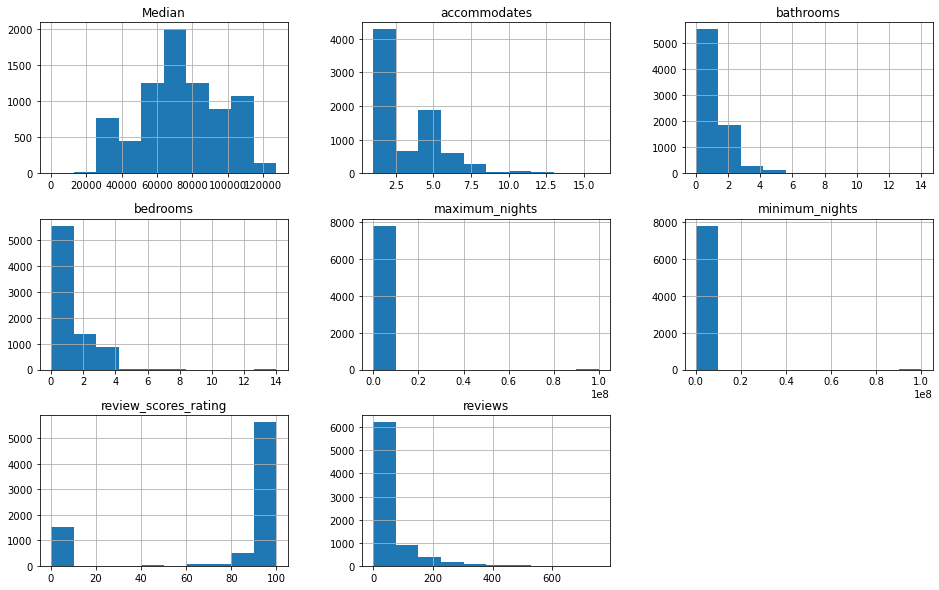

In [98]:
# Visualizatio using histogram
fig = plt.figure(figsize = (16,10))
ax = fig.gca()
data_complete_df3.hist(ax=ax)
plt.show()

### RandomForestRegressor with All Numerical Features

In [28]:
# Split our preprocessed data into our features and target arrays
target_y = cleaned_airbnb_df["price"]
features_X = numerical_df3

In [29]:
# Splitting into Train and Test sets.
features_X_train, features_X_test, target_y_train, target_y_test = train_test_split(features_X, target_y, test_size=0.20,
                                                                                        random_state=79)

In [30]:
# Determine the shape of our training and testing sets.
print(features_X_train.shape)
print(features_X_test.shape)
print(target_y_train.shape)
print(target_y_test.shape)

(6252, 6)
(1563, 6)
(6252,)
(1563,)


In [31]:
# Creating a StandardScaler instance.
#scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
#X_scaler = scaler.fit(features_X_train)

# Scaling the data.
#features_X_train_scaled = X_scaler.transform(features_X_train)
#features_X_test_scaled = X_scaler.transform(features_X_test)

In [32]:
# Instantiate the RandomForestRegressor model
rfrm = RandomForestRegressor(n_estimators=150, criterion="mse", max_depth=20)

In [33]:
# Fit the model
rfrm.fit(features_X_train, target_y_train)

RandomForestRegressor(max_depth=20, n_estimators=150)

In [34]:
# Predict total with test data
target_y_pred = rfrm.predict(features_X_test)

In [35]:
target_y_pred

array([132.17191908, 165.48116501, 272.54916162, ...,  89.54111111,
       186.01435555, 163.06349527])

In [36]:
#Calculate R2 Score for Model
print("R2 Score =", metrics.r2_score(target_y_test, target_y_pred))

#Calculate Root Mean Square Error
print("RMSE for RandomForestRegressor for Numerical Features Only =", 
      np.sqrt(mean_squared_error(target_y_test, target_y_pred)))

R2 Score = 0.13775408350583307
RMSE for RandomForestRegressor for Numerical Features Only = 429.4947422709384


In [37]:
rfrm.score(features_X, target_y)

0.48315916149955696

### RandomForestRegressor with accommodates, bedrooms, bathrooms and reviews

In [38]:
# Split our preprocessed data into our features and target arrays
target_y = cleaned_airbnb_df["price"]
features_X = four_numerical_features_df

In [39]:
# Splitting into Train and Test sets.
features_X_train, features_X_test, target_y_train, target_y_test = train_test_split(features_X, target_y, test_size=0.30,
                                                                                        random_state=78)

In [40]:
# Determine the shape of our training and testing sets.
print(features_X_train.shape)
print(features_X_test.shape)
print(target_y_train.shape)
print(target_y_test.shape)

(5470, 4)
(2345, 4)
(5470,)
(2345,)


In [41]:
# Creating a StandardScaler instance.
#scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
#X_scaler = scaler.fit(features_X_train)

# Scaling the data.
#features_X_train_scaled = X_scaler.transform(features_X_train)
#features_X_test_scaled = X_scaler.transform(features_X_test)

In [42]:
# Instantiate the RandomForestRegressor model
rfrm = RandomForestRegressor(n_estimators=150, criterion="mse", max_depth=20)

In [43]:
# Fit the model
rfrm.fit(features_X_train, target_y_train)

RandomForestRegressor(max_depth=20, n_estimators=150)

In [44]:
# Predict total with test data
target_y_pred = rfrm.predict(features_X_test)

In [45]:
target_y_pred

array([ 76.1129313 , 316.05353897, 162.90642891, ..., 227.81680263,
       224.05035342, 252.19362434])

In [46]:
#Calculate R2 Score for Model
print("R2 Score =", metrics.r2_score(target_y_test, target_y_pred))

#Calculate Root Mean Square Error
print("RMSE for RandomForestRegressor for Accommodates, Bedrooms, Bathrooms and Reviews Only =", 
      np.sqrt(mean_squared_error(target_y_test, target_y_pred)))

R2 Score = 0.030766657721495116
RMSE for RandomForestRegressor for Accommodates, Bedrooms, Bathrooms and Reviews Only = 486.32775286928467


In [47]:
rfrm.score(features_X, target_y)

0.15993921206337924

### RandomForestRegressor with accommodates, bedrooms, minimum_nights, maximum_nights and reviews

In [48]:
# Split our preprocessed data into our features and target arrays
target_y = cleaned_airbnb_df["price"]
features_X = five_numerical_features_df

In [49]:
# Splitting into Train and Test sets.
features_X_train, features_X_test, target_y_train, target_y_test = train_test_split(features_X, target_y, test_size=0.30,
                                                                                        random_state=78)

In [50]:
# Determine the shape of our training and testing sets.
print(features_X_train.shape)
print(features_X_test.shape)
print(target_y_train.shape)
print(target_y_test.shape)

(5470, 5)
(2345, 5)
(5470,)
(2345,)


In [51]:
# Creating a StandardScaler instance.
#scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
#X_scaler = scaler.fit(features_X_train)

# Scaling the data.
#features_X_train_scaled = X_scaler.transform(features_X_train)
#features_X_test_scaled = X_scaler.transform(features_X_test)

In [52]:
# Instantiate the RandomForestRegressor model
rfrm = RandomForestRegressor(n_estimators=150, criterion="mse", max_depth=20)

In [53]:
# Fit the model
rfrm.fit(features_X_train, target_y_train)

RandomForestRegressor(max_depth=20, n_estimators=150)

In [54]:
# Predict total with test data
target_y_pred = rfrm.predict(features_X_test)

In [55]:
target_y_pred

array([ 53.64813105, 188.06156659, 155.24741426, ..., 288.81612698,
       403.82176238, 442.74040936])

In [56]:
#Calculate R2 Score for Model
print("R2 Score =", metrics.r2_score(target_y_test, target_y_pred))

#Calculate Root Mean Square Error
print("RMSE for RandomForestRegressor for Accommodates, Bedrooms, Minimum Nights, Maximum Nights and Reviews Only =", 
      np.sqrt(mean_squared_error(target_y_test, target_y_pred)))

R2 Score = 0.20670479214612758
RMSE for RandomForestRegressor for Accommodates, Bedrooms, Minimum Nights, Maximum Nights and Reviews Only = 439.97935258903345


In [57]:
rfrm.score(features_X, target_y)

0.40622690822592356

### RandomForestRegressor with accommodates and bedrooms

In [58]:
# Split our preprocessed data into our features and target arrays
target_y = cleaned_airbnb_df["price"]
features_X = two_numerical_features_df

In [59]:
# Splitting into Train and Test sets.
features_X_train, features_X_test, target_y_train, target_y_test = train_test_split(features_X, target_y, test_size=0.30,
                                                                                        random_state=78)

In [60]:
# Determine the shape of our training and testing sets.
print(features_X_train.shape)
print(features_X_test.shape)
print(target_y_train.shape)
print(target_y_test.shape)

(5470, 2)
(2345, 2)
(5470,)
(2345,)


In [61]:
# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(features_X_train)

# Scaling the data.
features_X_train_scaled = X_scaler.transform(features_X_train)
features_X_test_scaled = X_scaler.transform(features_X_test)

In [62]:
# Instantiate the RandomForestRegressor model
rfrm = RandomForestRegressor(n_estimators=150)

In [63]:
# Fit the model
rfrm.fit(features_X_train_scaled, target_y_train)

RandomForestRegressor(n_estimators=150)

In [64]:
# Predict total with test data
target_y_pred = rfrm.predict(features_X_test_scaled)

In [65]:
target_y_pred

array([ 98.68154918, 178.87849168, 141.58946234, ..., 270.67826587,
       141.58946234, 381.63406133])

In [66]:
#Calculate R2 Score for Model
print("R2 Score =", metrics.r2_score(target_y_test, target_y_pred))

#Calculate Root Mean Square Error
print("RMSE for RandomForestRegressor for Accommodates and Bedrooms Only =", 
      np.sqrt(mean_squared_error(target_y_test, target_y_pred)))

R2 Score = 0.08125966999498813
RMSE for RandomForestRegressor for Accommodates and Bedrooms Only = 473.4905017547959


### Linear Regression ALL Features

In [67]:
from sklearn.linear_model import LinearRegression

In [68]:
import statsmodels.api as sm

In [69]:
# Train and split the data (split 80:20)
lm2 = LinearRegression()

target_linear_y = cleaned_airbnb_df["price"]
features_linear_X = data_complete_df2

features_linear_X_train, features_linear_X_test, target_linear_y_train, target_linear_y_test = train_test_split(
    features_linear_X, target_linear_y, test_size=0.2, random_state=101)

lm2.fit(features_linear_X_train, target_linear_y_train)

LinearRegression()

In [70]:
# Predictions
predictions2 = lm2.predict(features_linear_X_test)

print(predictions2)

[621.19706595  76.70031339 122.76049986 ... 182.92331573 266.91875023
  79.46409616]


In [71]:
# Evaluate the metrics
mae = mean_absolute_error(target_linear_y_test, predictions2)
mse = mean_squared_error(target_linear_y_test, predictions2)
rmse = np.sqrt(mean_squared_error(target_linear_y_test, predictions2))
r2 = metrics.r2_score(target_linear_y_test, predictions2)

print('MAE (Mean-Absolute-Error): %s' %mae)
print('MSE (Mean-Squared-Error): %s' %mse)
print('RMSE (Root-MSE): %s' %rmse)
print('R2 score: %s' %r2)

MAE (Mean-Absolute-Error): 124.38144872547798
MSE (Mean-Squared-Error): 213833.8597974286
RMSE (Root-MSE): 462.4217336992592
R2 score: 0.10545439069374207


In [72]:
# training using statmodel

linear_model_sm = sm.OLS(target_linear_y_train,sm.tools.add_constant(features_linear_X_train).astype(float))
results_sm = linear_model_sm.fit()
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     15.89
Date:                Sat, 20 Mar 2021   Prob (F-statistic):          5.51e-166
Time:                        13:48:59   Log-Likelihood:                -45832.
No. Observations:                6252   AIC:                         9.180e+04
Df Residuals:                    6183   BIC:                         9.227e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### RandomForestRegressor with ALL Features

In [73]:
# Split our preprocessed data into our features and target arrays
target_y = cleaned_airbnb_df["price"]
features_X = data_complete_df2

In [74]:
# Splitting into Train and Test sets.
features_X_train, features_X_test, target_y_train, target_y_test = train_test_split(features_X, target_y, test_size=0.30,
                                                                                        random_state=78)

In [75]:
# Determine the shape of our training and testing sets.
print(features_X_train.shape)
print(features_X_test.shape)
print(target_y_train.shape)
print(target_y_test.shape)

(5470, 73)
(2345, 73)
(5470,)
(2345,)


In [76]:
# Creating a StandardScaler instance.
#scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
#X_scaler = scaler.fit(features_X_train)

# Scaling the data.
#features_X_train_scaled = X_scaler.transform(features_X_train)
#features_X_test_scaled = X_scaler.transform(features_X_test)

In [77]:
# Instantiate the RandomForestRegressor model
#rfrm = RandomForestRegressor(n_estimators=150)

In [78]:
kf = KFold(n_splits=5, shuffle=True, random_state=27)
rfrm = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=20, min_samples_split=2)
cv_score = cross_val_score(rfrm, features_X_train, target_y_train, scoring='r2', cv=kf)
cv_score

array([ 0.64681829,  0.02049231, -0.4020112 ,  0.59418374, -0.55531463])

In [79]:
# Fit the model
rfrm.fit(features_X_train, target_y_train)

RandomForestRegressor(max_depth=20)

In [80]:
# Predict total with test data
target_y_pred = rfrm.predict(features_X_test)

In [81]:
target_y_pred

array([ 64.4114118 , 200.16866949, 133.06935334, ..., 274.34216056,
        92.13611124, 399.75838164])

In [82]:
#Calculate R2 Score for Model
print("R2 Score =", metrics.r2_score(target_y_test, target_y_pred))

#Calculate Root Mean Square Error
print("RMSE for RandomForestRegressor for All Features =", 
      np.sqrt(mean_squared_error(target_y_test, target_y_pred)))

R2 Score = 0.5958389459936885
RMSE for RandomForestRegressor for All Features = 314.045165157468


In [83]:
rfrm.score(features_X, target_y)

0.7755047032817834

### RandomForestRegressor without kfold and cv; Parameter tuning by using: n_estimators=500 and max_features='auto' to fit the random forest regressor

In [84]:
# final model using the parameter tuning
rf_regressor = RandomForestRegressor(n_estimators=500,
                                     oob_score=True,
                                     n_jobs=-1,
                                     random_state=42,
                                     max_features='auto')

In [85]:
rf_regressor.fit(features_X_train, target_y_train)
rf_regressor.score(features_X_train, target_y_train)

0.9133780345036909

In [86]:
# Predict total with test data
target_y_pred2 = rf_regressor.predict(features_X_test)

In [87]:
#Calculate R2 Score for Model
print("R2 Score =", metrics.r2_score(target_y_test, target_y_pred2))

#Calculate Root Mean Square Error
print("RMSE for RandomForestRegressor for All Features =", 
      np.sqrt(mean_squared_error(target_y_test, target_y_pred2)))

R2 Score = 0.6060482373216758
RMSE for RandomForestRegressor for All Features = 310.053333473907


### RandomForestRegressor with room_type, accommodates, bedrooms, minimum_nights and review_scores_rating

In [88]:
# Split our preprocessed data into our features and target arrays
target_y = cleaned_airbnb_df["price"]
features_X = room_four_other_features_df

In [89]:
# Splitting into Train and Test sets.
features_X_train, features_X_test, target_y_train, target_y_test = train_test_split(features_X, target_y, test_size=0.30,
                                                                                        random_state=78)

In [90]:
# Determine the shape of our training and testing sets.
print(features_X_train.shape)
print(features_X_test.shape)
print(target_y_train.shape)
print(target_y_test.shape)

(5470, 8)
(2345, 8)
(5470,)
(2345,)


In [91]:
# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(features_X_train)

# Scaling the data.
features_X_train_scaled = X_scaler.transform(features_X_train)
features_X_test_scaled = X_scaler.transform(features_X_test)

In [92]:
# Instantiate the RandomForestRegressor model
rfrm = RandomForestRegressor(n_estimators=100)

In [93]:
# Fit the model
rfrm.fit(features_X_train_scaled, target_y_train)

RandomForestRegressor()

In [94]:
# Predict total with test data
target_y_pred = rfrm.predict(features_X_test_scaled)

In [95]:
target_y_pred

array([ 76.70816495, 190.07423129, 127.22000766, ..., 292.34742857,
       109.05706566, 587.77109848])

In [96]:
#Calculate R2 Score for Model
print("R2 Score =", metrics.r2_score(target_y_test, target_y_pred))

#Calculate Root Mean Square Error
print("RMSE for RandomForestRegressor for Room Type, Accomodates, Bedrooms, Minimum Nights and Review Scores Rating =", 
      np.sqrt(mean_squared_error(target_y_test, target_y_pred)))

R2 Score = 0.2432740087817512
RMSE for RandomForestRegressor for Room Type, Accomodates, Bedrooms, Minimum Nights and Review Scores Rating = 429.71865366084177
